<a href="https://colab.research.google.com/github/VictorFrancheto/Complex_Network/blob/main/__Notebook_Synchronization__.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Synchronization in Complex Networks and Applications**


---





Victor Hugo F. Francheto

University of São Paulo, SP

victor.francheto@usp.br



Bruno B. Pereira

University of São Paulo, SP

bruno.pereira@usp.br


---


**Chosen Topic:**

### **5 - How is synchronization influenced by network topology?**

See: [https://github.com/fabridamicelli/kuramoto](https://github.com/fabridamicelli/kuramoto)

Refer to the article:
[Synchronization in complex networks](https://www.sciencedirect.com/science/article/pii/S0370157308003384)

Generate networks using different models and observe how synchronization changes according to the model. A graph of the order parameter ($r$) as a function of coupling $\lambda$ can be plotted.

Analyze how community structure affects synchronization by adjusting the parameter $\mu$ in the LFR model that generates modular networks.

### Importing libraries

In [ ]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.integrate import *
from scipy.special import zeta
from numpy import linalg as LA
from pylab import *
import math
import community.community_louvain as community_louvain

## Introduction to the Kuramoto Model

The Kuramoto model, proposed by physicist Yoshiki Kuramoto in the 1970s, is a mathematical model used to describe the synchronization of coupled oscillator systems. This model is widely applied in various fields such as physics, biology, engineering, and even social sciences, due to its ability to capture the essence of synchronization phenomena in complex systems.

### Model Description

The Kuramoto model for complex networks considers a set of $N$ oscillators, each with a phase $\theta_i(t)$ and a natural frequency $\omegThe dynamics of each oscillator are described by the following differential equationuation:

$$
\frac{d\theta_i}{dt} = \omega_i + \lambda \sum_{j=1}^{N} A_{ij} \sin(\theta_j - \theta_i),
$$

where:

- $\theta_i(t)$ is the phase of the $i$-th oscillator at time $t$;
- $\omega_i$ is the natural frequency of the $i$-th oscillator;
- $\lambda$ is the coupling strength between the oscillators;
- $A_{ij}$ is the adjacency matrix of the network, where $A_{ij} = 1$ if there is a connection between oscillator $i$ and oscillator $j$, and $A_{ij} = 0$ otherwise.

### Synchronization

The interest in the Kuramoto model lies in its ability to describe how independent oscillators, when coupled, can synchronize their phases. In particular, depending on the value of the coupling strength $\lambda$, the system can transition from a disordered state (where the oscillators have independent phases) to a synchronized state (where all oscillators oscillate in unison).

### Network Topologies

To study synchronization in different network topologies, the Kuramoto model can be adapted by considering different forms of connectivity among the oscillators. Some common topologies include:

- **Complete Network:** Each oscillator is couple; to every other oscillator.
- **Ring Network:** Each oscillator is coupled only to its;nearest neighbors in a ring.
- **Complex Networks:** These include topologies such as small-world networks and scale-free networks, which capture the structure of many real-world networks, such as neural and social networks.

By exploring the synchronization behavior of the Kuramoto model in different topologies, it is possible to gain insights into how network structure influences the emergence of synchronization, which has important implications for understanding complex dynamic systems in various disciplines.
ystems in various disciplines.
stems in various disciplines.
stems in various disciplines.


### Implementing the Kuramoto model

To have greater flexibility in choosing the parameters for the Kuramoto model, we will implement the model manually instead of using a pre-existing library.

In [ ]:
# First-order Kuramoto model
def F(Y, t, G, W, lbd):
    #global W, N, lbd, G
    N = len(G.nodes())
    F = zeros((N),float)
    S = zeros((N),float)
    dg = G.degree()
    for i in range(0, N):
        for j in G.neighbors(i):
            S[i] = S[i] + sin(Y[j]-Y[i])
    ld = lbd
    F = W + ld*S #traditional Kuramoto
    return F

### Function to extract synchronization parameters

In [ ]:
def calculate_sync(G):
    # Removing network direction
    G = G.to_undirected()

    # Converting node labels to integers
    G = nx.convert_node_labels_to_integers(G, first_label=0)

    # Number of nodes
    N = len(G)

    # Degree calculation
    vk = dict(G.degree())
    vk = list(vk.values())
    av_k = mean(vk)  # Average degree

    # Creating adjacency matrix
    A = nx.adjacency_matrix(G)
    A = A.todense()  # Adjusting the matrix

    # Calculating eigenvalues
    eig, vectors = LA.eig(A)
    lambda_max = eig.max()  # Getting the largest eigenvalue

    # Initial phases
    w0 = np.pi
    y0 = np.random.normal(0, w0, size=N)

    # Natural frequency
    W = np.random.uniform(-w0, w0, size=N)

    # Critical coupling
    hist, bin_edges = np.histogram(W, density=True)
    g0 = max(hist)
    lambda_c = 2 / (np.pi * lambda_max * g0)

    # Integration time
    t0 = 0.0  # Start
    h = 0.02  # Increment
    Np = 3000  # Number of interactions
    tStop = int(Np * h)  # Integration end
    t = np.linspace(t0, tStop, Np)

    # Synchronization process
    vlbd = []  # vector that stores the coupling strength
    aux = 0
    Ns = 1  # Number of Simulations
    vlbd = np.arange(0, 10 * lambda_c, lambda_c / 5)  # variation of the coupling strength
    mvr = np.zeros(shape=shape(vlbd))
    for s in np.arange(0, Ns):
        vr = []  # vector that stores the order parameter
        for lbd in vlbd:
            y = odeint(F, y0, t, (G, W, lbd))
            y = np.array(y)
            y = y[range(len(y) - round(0.9 * len(y)), len(y)), :]
            y = y.mean(0)
            psi = mean(y)
            r = abs((1.0 / N) * sum(np.exp(1j * y)))
            vr.append(r)
            aux = aux + 1
            y0 = y  # adiabatic increase
        mvr = mvr + vr
    mvr = mvr / Ns
    vlbd = np.array(vlbd, dtype=float)
    if len(mvr) != len(vlbd):
        min_length = min(len(vlbd), len(mvr))
        vlbd = vlbd[:min_length]
        mvr = mvr[:min_length]

    return vlbd, mvr, lambda_c

Let's generate some networks for later synchronization analysis.

### Creating networks with and without community structures

### Function Descriptions

- **network_with_communities:** Creates a network with defined community structure using the random partition model.
- **network_with_LFR_communities:** Generates a network with communities based on the LFR benchmark graph.
- **erdos_renyi_network:** Creates an Erdős-Rényi network with given parameters.
- **small_world_network:** Generates a Small World network using the Watts-Strogatz model.
- **barabasi_albert_network:** Creates a scale-free network using the Barabási-Albert model.
- **waxman_network:** Generates a Waxman network with the specified number of nodes and seed.
- **plot_network:** Plots the given network, removing self-loops and focusing on the largest connected component.


In [ ]:
def network_with_communities(partition_sizes, p_in, p_out, seed):
    # Define sizes of partitions (communities)
    partition_sizes = partition_sizes

    # Define connection probabilities
    p_in = p_in  # Probability of edge within the same community
    p_out = p_out  # Probability of edge between different communities

    # Generate the random partitioned graph
    G = nx.random_partition_graph(partition_sizes, p_in, p_out, seed=seed)
    return G

# Generates a stochastic block model graph
def stochastic_block_model_graph(partition_sizes, p_in, p_out, seed=None):
    """
    Parameters:
    - partition_sizes: List of sizes of partitions (communities).
    - p_in: Probability of edge within the same community.
    - p_out: Probability of edge between different communities.
    - seed: Seed for random number generator (default is None).

    Returns:
    - G: A NetworkX graph generated using the stochastic block model.
    """

    # Define the probability matrix p
    p = [
        [p_in, p_out, p_out],
        [p_out, p_in, p_out],
        [p_out, p_out, p_in]
    ]

    # Generate stochastic block model graph
    G = nx.stochastic_block_model(partition_sizes, p, seed=seed)

    return G


# Girvan and Newman network
def g_v_graph(k, kout):
    k = k
    kout = kout
    kin = k - kout
    pin = kin / 32
    pout = kout / (128 - 32)

    G = nx.random_partition_graph([32, 32, 32, 32],pin, pout)

    return G


def network_with_LFR_communities(N, tau1, tau2, mu, k, minc, maxc):
    # Set the parameters
    N = N
    tau1 = tau1
    tau2 = tau2
    mu = mu
    k = k
    minc = minc
    maxc = maxc

    # Generate the LFR benchmark graph
    G = nx.LFR_benchmark_graph(n=N, tau1=tau1, tau2=tau2, mu=mu, min_degree=k,
                               max_degree=k, min_community=minc, max_community=maxc, seed=seed)
    return G

def erdos_renyi_network(N, p, seed):
    # Set the parameters
    N = N
    p = p
    seed = seed

    # Generate the Erdős-Rényi graph
    G = nx.gnp_random_graph(N, p, seed=seed, directed=False)
    return G

def small_world_network(N, k, p, seed):
    # Set the parameters
    N = N
    k = k
    p = p
    seed = seed
    k = int(k)

    # Generate the Small World graph
    G = nx.watts_strogatz_graph(N, k, p, seed)
    return G

def barabasi_albert_network(N, m):
    # Set the parameter
    m = m

    # Generate the Barabási-Albert graph
    G = nx.barabasi_albert_graph(N, m)
    return G

def waxman_network(N, seed):
    # Set the parameter
    seed = seed

    # Generate the Waxman graph
    G = nx.waxman_graph(N, seed)
    return G


def plot_network(G, ax = None):
    # Remove self-loops
    G.remove_edges_from(nx.selfloop_edges(G))

    # Get the largest connected component
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G = G.subgraph(Gcc[0])

    # Relabel nodes starting from 0
    G = nx.convert_node_labels_to_integers(G, first_label=0)

    # Compute the layout and plot the network
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color="c", node_size=10, with_labels=False, ax=ax)

### The nonlinear Barabási-Albert model

The nonlinear Barabási-Albert model is an extension of the classic Barabási-Albert model, which is used to create scale-free networks. In the classic model, new nodes are added to the network with a probability that is proportional to the degree of existing nodes. This means that nodes with more connections are more likely to get new connections, leading to a degree distribution that follows a power law.

In the nonlinear Barabási-Albert model, the probability of a new node connecting to an existing node is not necessarily linear in relation to the degree of the existing node. Instead, the probability is proportional to the degree raised to a power \(\alpha\):

$$\Pi(k_i) \propto k_i^\alpha,$$

where:
- $\Pi(k_i)$ is the probability of a new node connecting to an existing node $i$ with degree $k_i$;
- $\alpha$ is a parameter that adjusts the nonlinearity.

Depending on the value of $\alpha$, the network's behavior changes:
- For $\alpha = 1$, the model becomes the classic linear Barabási-Albert model;
- For $\alpha < 1$, the growth is sublinear, meaning new nodes have a relatively higher chance of getting connections, and the preferential attachment is less strong;
- For $\alpha > 1$, the growth is superlinear, meaning the preferential attachment is stronger, leading to more pronounced hubs (nodes with very high degrees);

This variation allows for the creation of networks with different structures and properties by adjusting the degree of heterogeneity in the distribution of connections.

The nonlinear Barabási-Albert model does not have a built-in library available in `networkx`, so we will implement it ourselves.


### Implementing the Nonlinear Barabási-Albert Model

In [ ]:
def nonlinear_barabasi_albert_graph(N, m, alpha):
    """
    Creates a nonlinear Barabási-Albert graph.

    Parameters:
    - N: Total number of nodes in the graph.
    - m: Number of edges to attach from a new node to existing nodes.
    - alpha: Nonlinearity parameter.

    Returns:
    - G: A NetworkX graph generated using the nonlinear Barabási-Albert model.
    """

    # Set the seed for reproducibility
    np.random.seed(42)

    # Start with a complete graph of m nodes
    G = nx.complete_graph(m)

    # List of target nodes for new edges
    target_nodes = list(range(m))
    # List to track nodes with their degrees
    repeated_nodes = []

    # Add new nodes with preferential attachment
    for source in range(m, N):
        # Calculate attachment probabilities
        probs = np.array([G.degree(node) ** alpha for node in target_nodes], dtype=np.float64)
        norm_probs = probs / probs.sum()

        # Select m target nodes based on probabilities
        new_edges = np.random.choice(target_nodes, size=m, replace=False, p=norm_probs)

        # Add edges from the new node to selected nodes
        G.add_edges_from(zip([source] * m, new_edges))

        # Update target nodes and repeated nodes list
        target_nodes.append(source)
        repeated_nodes.extend(new_edges)
        repeated_nodes.extend([source] * m)

    return G


### Network parameters

Let's generate some networks to study how network topology affects network synchronization. Next, we'll pre-define the parameters of the networks.

In [ ]:
# >>Network Parameters<< #

# Number of nodes
N = 150

# Average degree
av_degree = 6

# Connection probability for Erdős–Rényi models
p = float(av_degree)/float(N)

# Number of nodes added at each time step in the Barabasi-Albert and Waxman models
m = int(av_degree/2)

# Number of neighbors in the Small World model
kappa = av_degree

# >>Parameters for Networks with Communities<< #

# Define sizes of partitions (communities)
partition_sizes = [30, 30, 20]

# Probability of edge within the same community
p_in = 0.5

# Probability of edge between different communities
p_out = 0.02

seed = 42

# >>Parameters for LFV Networks with Communities<< #
tau1 = 2
tau2 = 2
mu = 0.1
minc = 20
maxc = 200

Let's start by analyzing the synchronization of a network with well-defined communities.

### Generating networks with community structures

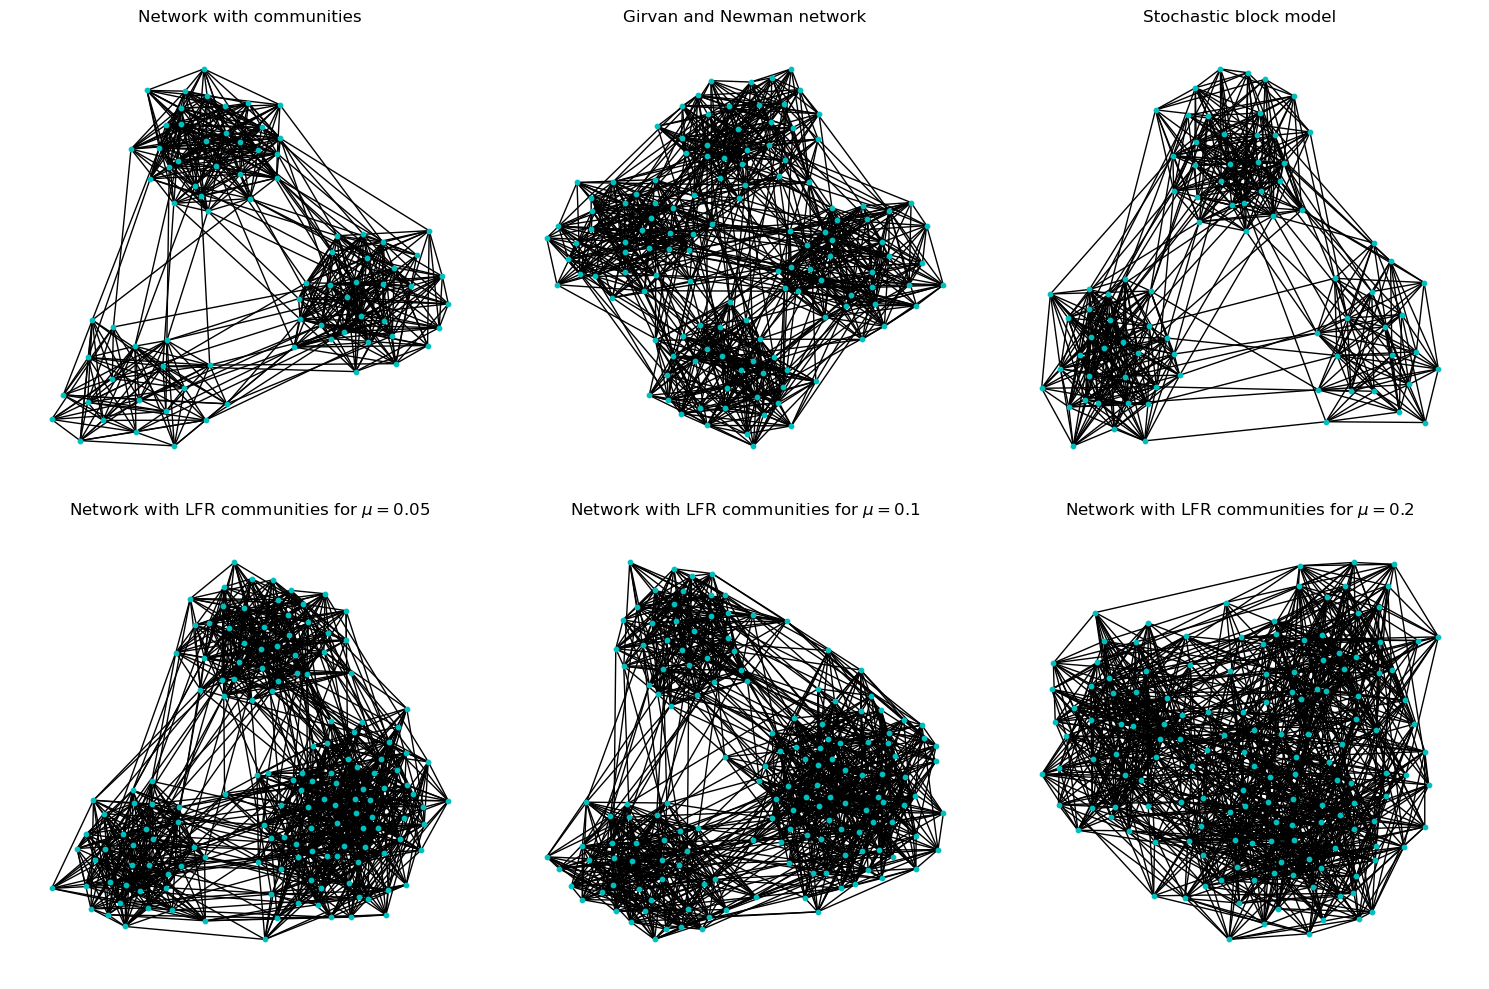

In [ ]:
G_1 = nx.Graph()
G_1 = network_with_communities(partition_sizes, p_in, p_out, seed)
vlbd_1, mvr_1, lambda_c1 = calculate_sync(G_1)

G_2 =  nx.Graph()
G_2 = g_v_graph(16, 3)
vlbd_2, mvr_2, lambda_c2 = calculate_sync(G_2)

G_3 = nx.Graph()
G_3 = stochastic_block_model_graph(partition_sizes, p_in, p_out, seed)
vlbd_3, mvr_3, lambda_c3 = calculate_sync(G_3)

G_4 = nx.Graph()
G_4 = network_with_LFR_communities(N, tau1, tau2, 0.05, kappa*2, minc, maxc)
vlbd_4, mvr_4, lambda_c4 = calculate_sync(G_4)

G_5 = nx.Graph()
G_5 = network_with_LFR_communities(N, tau1, tau2, 0.1, kappa*2, minc, maxc)
vlbd_5, mvr_5, lambda_c5 = calculate_sync(G_5)

G_6 = nx.Graph()
G_6 = network_with_LFR_communities(N, tau1, tau2, 0.2, kappa*2, minc, maxc)
vlbd_6, mvr_6, lambda_c6 = calculate_sync(G_6)


# Creation of the figure and subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plotting the graphs
plot_network(G_1, ax=axes[0, 0])
axes[0, 0].set_title("Network with communities")

plot_network(G_2, ax=axes[0, 1])
axes[0, 1].set_title("Girvan and Newman network")

plot_network(G_3, ax=axes[0, 2])
axes[0, 2].set_title("Stochastic block model")

plot_network(G_4, ax=axes[1, 0])
axes[1, 0].set_title("Network with LFR communities for $\mu=0.05$")

plot_network(G_5, ax=axes[1, 1])
axes[1, 1].set_title("Network with LFR communities for $\mu=0.1$")

plot_network(G_6, ax=axes[1, 2])
axes[1, 2].set_title("Network with LFR communities for $\mu=0.2$")

# Adjusting the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


### Plotting network synchronization

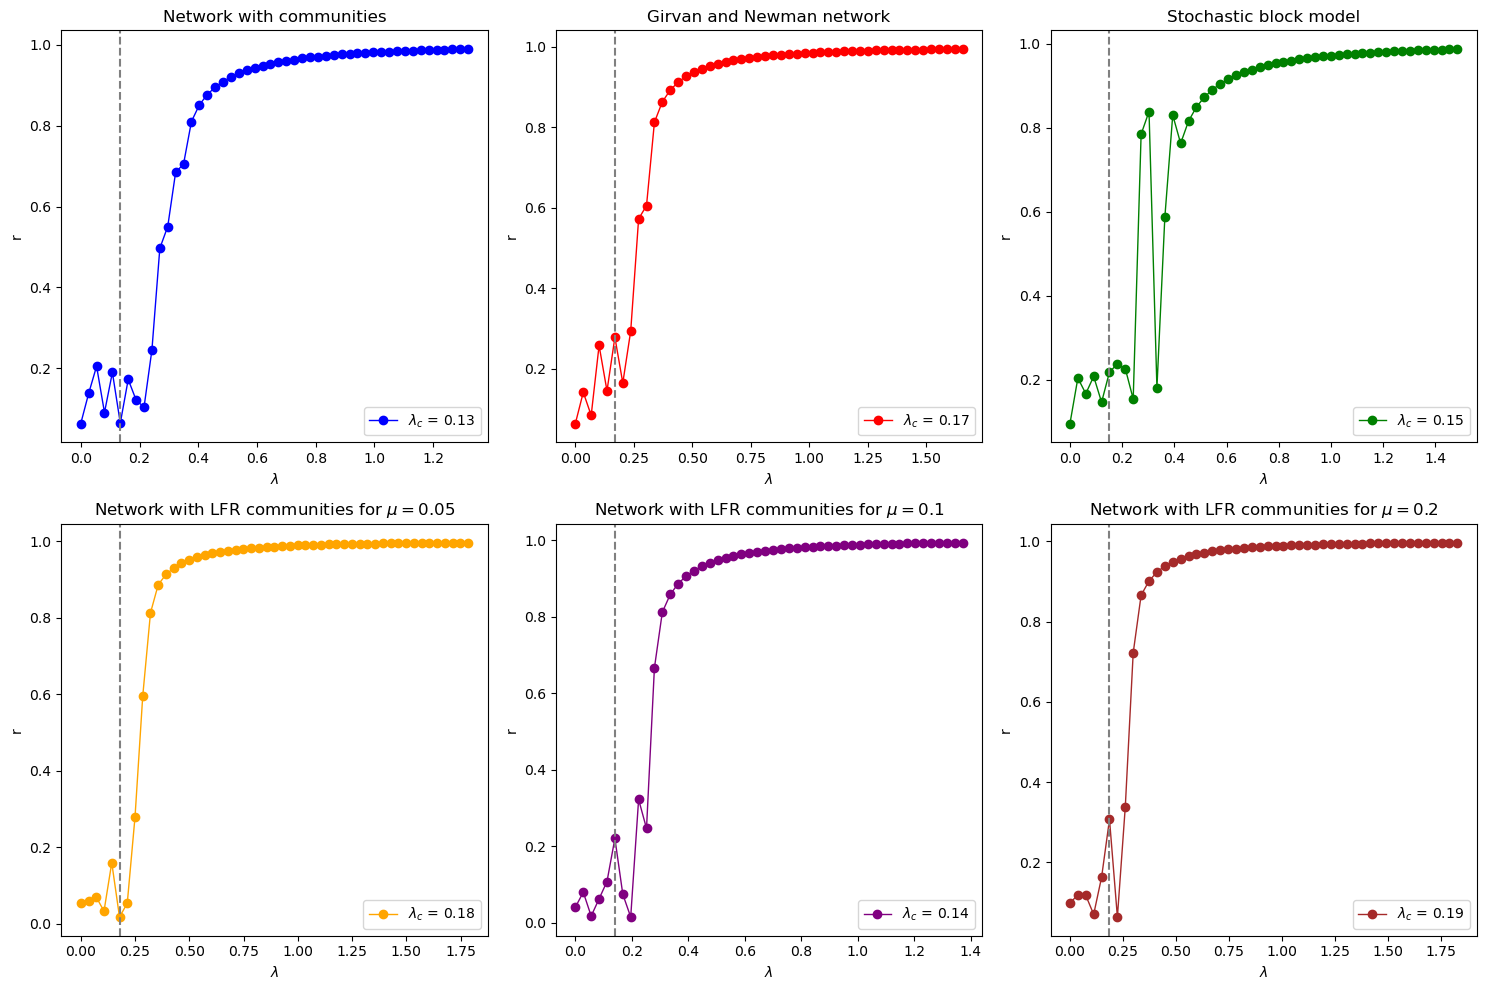

In [ ]:
plt.figure(figsize=(15, 10))

# First plot
plt.subplot(2, 3, 1)
plt.plot(vlbd_1, mvr_1, '-o', color='blue', linewidth=1, label=f'$\lambda_c$ = {lambda_c1:.2f}')
plt.axvline(x=lambda_c1, color='gray', linestyle='--')
plt.xlabel(r"$\lambda$")
plt.ylabel("r")
plt.title("Network with communities")
plt.legend()

# Second plot
plt.subplot(2, 3, 2)
plt.plot(vlbd_2, mvr_2, '-o', color='red', linewidth=1, label=f'$\lambda_c$ = {lambda_c2:.2f}')
plt.axvline(x=lambda_c2, color='gray', linestyle='--')
plt.xlabel(r"$\lambda$")
plt.ylabel("r")
plt.title("Girvan and Newman network")
plt.legend()

# Third plot
plt.subplot(2, 3, 3)
plt.plot(vlbd_3, mvr_3, '-o', color='green', linewidth=1, label=f'$\lambda_c$ = {lambda_c3:.2f}')
plt.axvline(x=lambda_c3, color='gray', linestyle='--')
plt.xlabel(r"$\lambda$")
plt.ylabel("r")
plt.title("Stochastic block model")
plt.legend()

# Fourth plot
plt.subplot(2, 3, 4)
plt.plot(vlbd_4, mvr_4, '-o', color='orange', linewidth=1, label=f'$\lambda_c$ = {lambda_c4:.2f}')
plt.axvline(x=lambda_c4, color='gray', linestyle='--')
plt.xlabel(r"$\lambda$")
plt.ylabel("r")
plt.title("Network with LFR communities for $\mu=0.05$")
plt.legend()

# Fifth plot
plt.subplot(2, 3, 5)
plt.plot(vlbd_5, mvr_5, '-o', color='purple', linewidth=1, label=f'$\lambda_c$ = {lambda_c5:.2f}')
plt.axvline(x=lambda_c5, color='gray', linestyle='--')
plt.xlabel(r"$\lambda$")
plt.ylabel("r")
plt.title("Network with LFR communities for $\mu=0.1$")
plt.legend()

# Sixth plot
plt.subplot(2, 3, 6)
plt.plot(vlbd_6, mvr_6, '-o', color='brown', linewidth=1, label=f'$\lambda_c$ = {lambda_c6:.2f}')
plt.axvline(x=lambda_c6, color='gray', linestyle='--')
plt.xlabel(r"$\lambda$")
plt.ylabel("r")
plt.title("Network with LFR communities for $\mu=0.2$")
plt.legend()

plt.tight_layout()
plt.show()


### Generating networks without community structures

C:\Users\victo\AppData\Local\Temp\ipykernel_21684\1785878281.py:63: ComplexWarning: Casting complex values to real discards the imaginary part
  vlbd = np.array(vlbd, dtype=float)


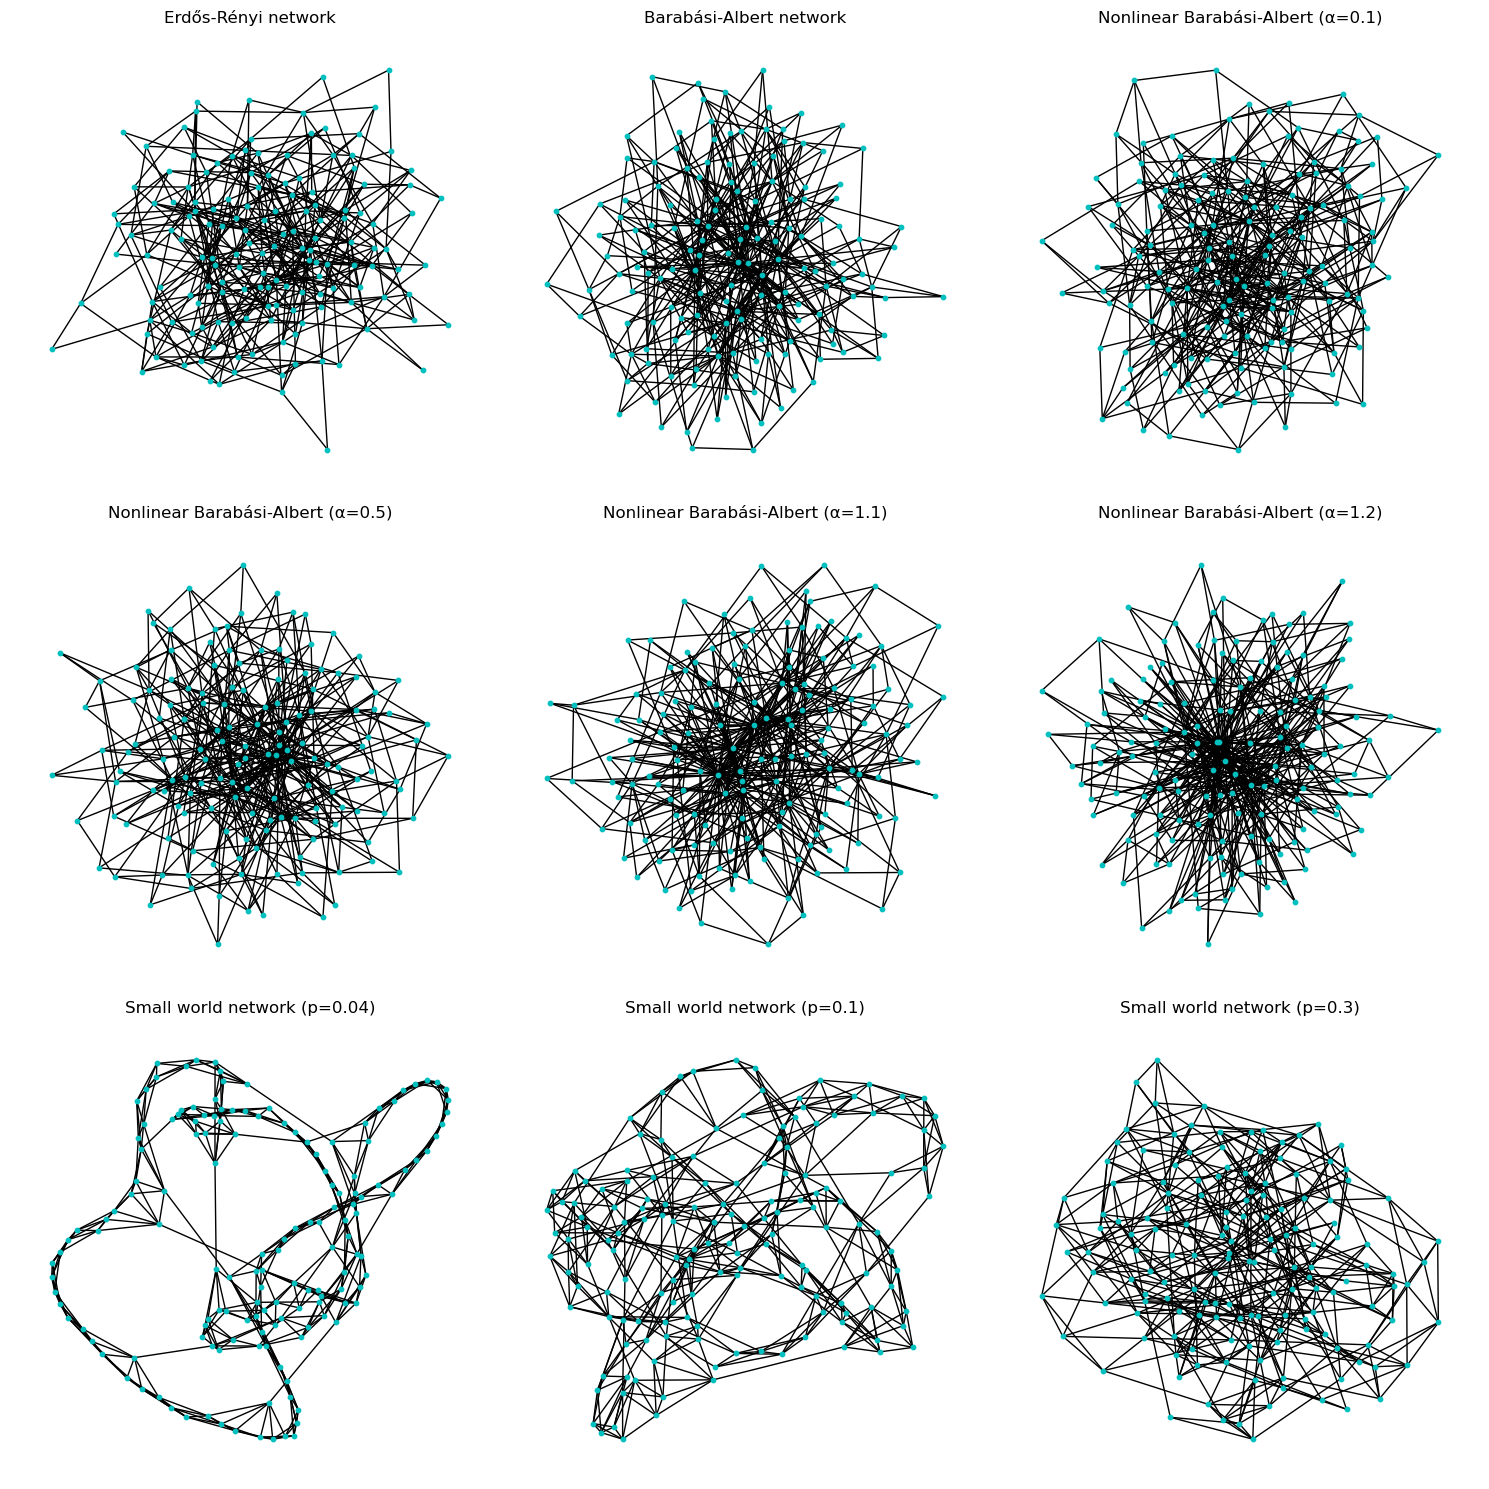

In [ ]:
# First plot: Erdős-Rényi network
G_1 = erdos_renyi_network(N, p, seed)
vlbd_1, mvr_1, lambda_c1 = calculate_sync(G_1)

# Second plot: Barabási-Albert network
G_2 = barabasi_albert_network(N, m)
vlbd_2, mvr_2, lambda_c2 = calculate_sync(G_2)

# Third plot: Nonlinear Barabási-Albert network with alpha = 0.1
G_3 = nonlinear_barabasi_albert_graph(N, m, 0.1)
vlbd_3, mvr_3, lambda_c3 = calculate_sync(G_3)

# Fourth plot: Nonlinear Barabási-Albert network with alpha = 0.5
G_4 = nonlinear_barabasi_albert_graph(N, m, 0.5)
vlbd_4, mvr_4, lambda_c4 = calculate_sync(G_4)

# Fifth plot: Nonlinear Barabási-Albert network with alpha = 1.1
G_5 = nonlinear_barabasi_albert_graph(N, m, 1.1)
vlbd_5, mvr_5, lambda_c5 = calculate_sync(G_5)

# Sixth plot: Nonlinear Barabási-Albert network with alpha = 1.2
G_6 = nonlinear_barabasi_albert_graph(N, m, 1.2)
vlbd_6, mvr_6, lambda_c6 = calculate_sync(G_6)

# Seventh plot: Small world network for p = 0.04
G_7 = small_world_network(N, kappa, 0.04, seed)
vlbd_7, mvr_7, lambda_c7 = calculate_sync(G_7)

# Eighth plot: Small world network for p = 0.1
G_8 = small_world_network(N, kappa, 0.1, seed)
vlbd_8, mvr_8, lambda_c8 = calculate_sync(G_8)

# Ninth plot: Small world network for p = 0.3
G_9 = small_world_network(N, kappa, 0.3, seed)
vlbd_9, mvr_9, lambda_c9 = calculate_sync(G_9)

# Creation of the figure and subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Plotting the graphs
plot_network(G_1, ax=axes[0, 0])
axes[0, 0].set_title("Erdős-Rényi network")

plot_network(G_2, ax=axes[0, 1])
axes[0, 1].set_title("Barabási-Albert network")

plot_network(G_3, ax=axes[0, 2])
axes[0, 2].set_title("Nonlinear Barabási-Albert (α=0.1)")

plot_network(G_4, ax=axes[1, 0])
axes[1, 0].set_title("Nonlinear Barabási-Albert (α=0.5)")

plot_network(G_5, ax=axes[1, 1])
axes[1, 1].set_title("Nonlinear Barabási-Albert (α=1.1)")

plot_network(G_6, ax=axes[1, 2])
axes[1, 2].set_title("Nonlinear Barabási-Albert (α=1.2)")

plot_network(G_7, ax=axes[2, 0])
axes[2, 0].set_title("Small world network (p=0.04)")

plot_network(G_8, ax=axes[2, 1])
axes[2, 1].set_title("Small world network (p=0.1)")

plot_network(G_9, ax=axes[2, 2])
axes[2, 2].set_title("Small world network (p=0.3)")

# Adjusting the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


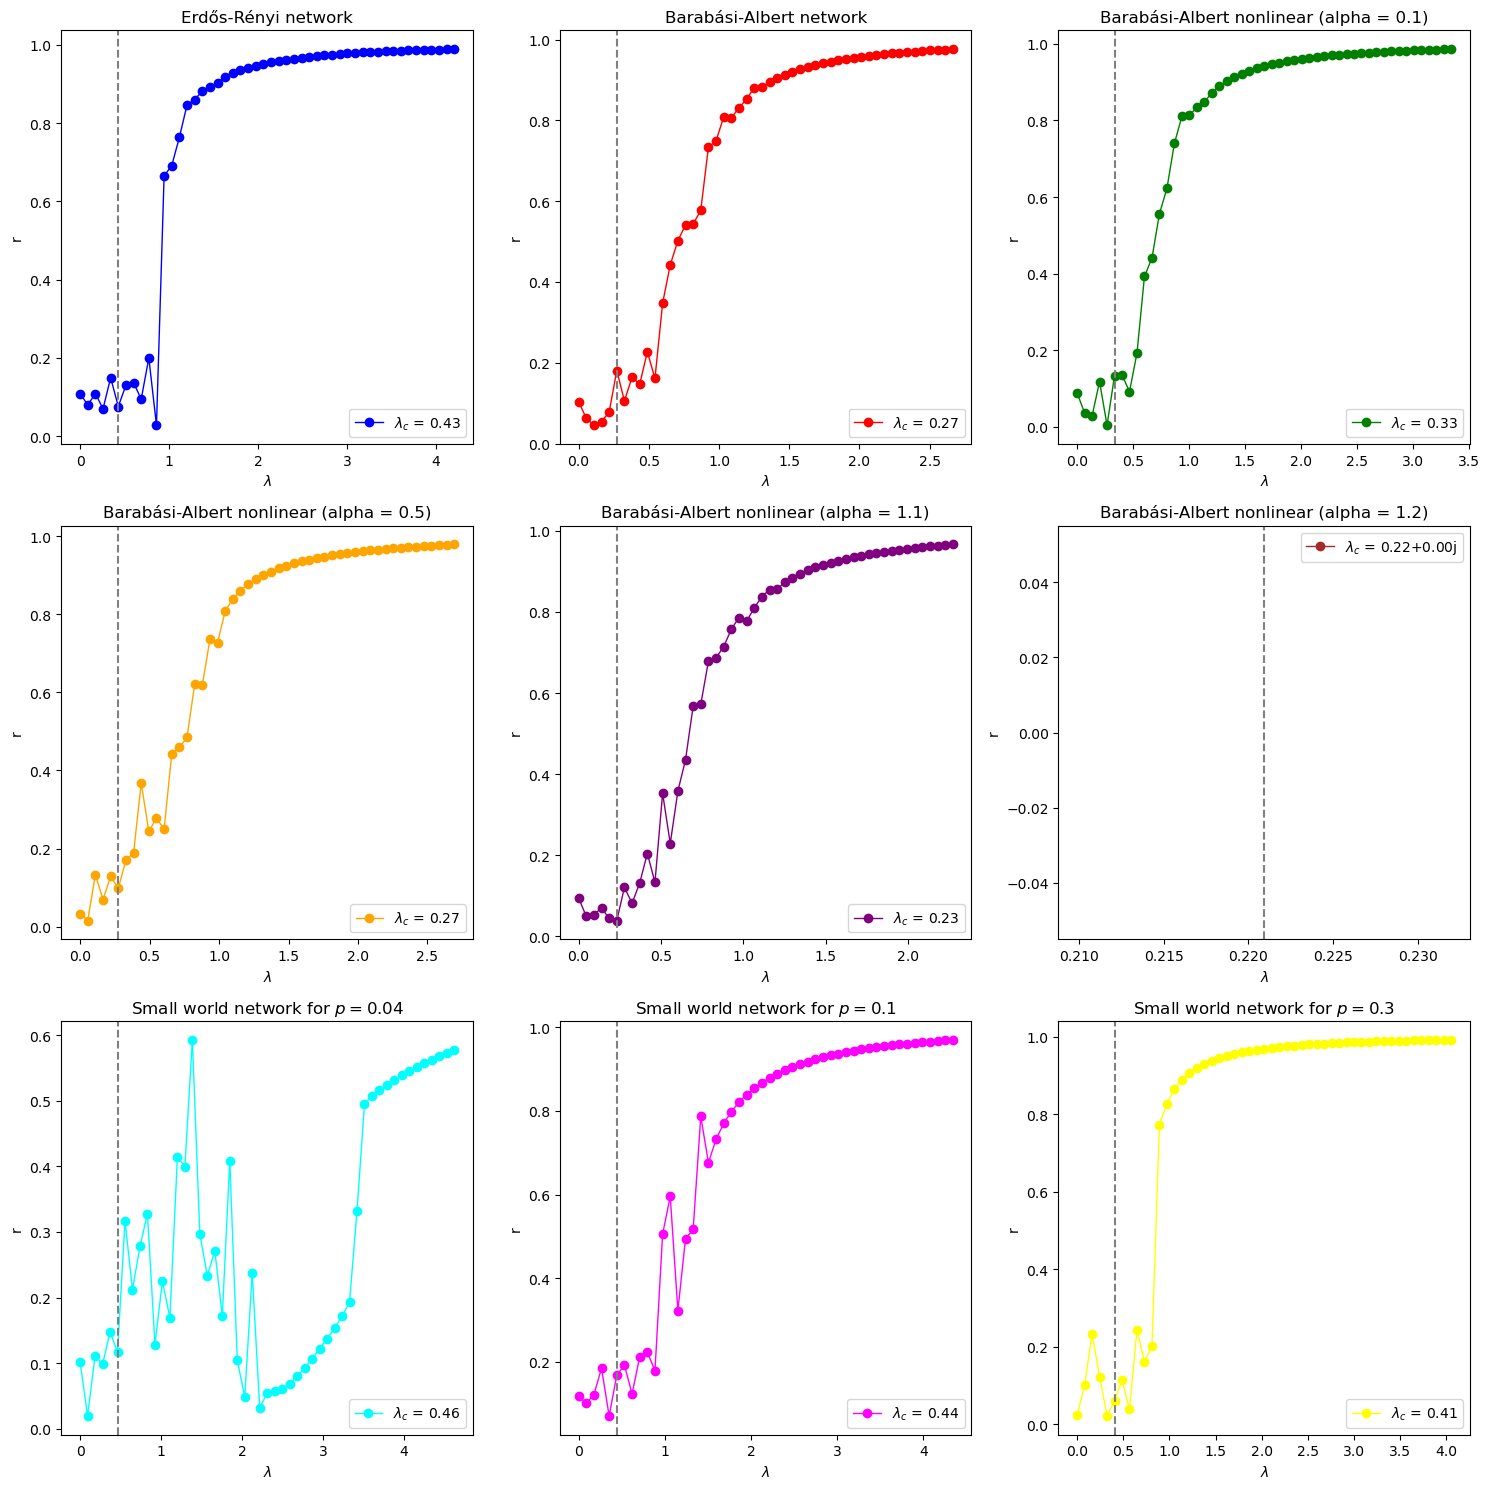

In [ ]:
plt.figure(figsize=(15, 15))

# First plot: Erdős-Rényi network
plt.subplot(3, 3, 1)
plt.plot(vlbd_1, mvr_1, '-o', color='blue', linewidth=1, label=f'$\lambda_c$ = {lambda_c1:.2f}')
plt.axvline(x=lambda_c1, color='gray', linestyle='--')
plt.xlabel(r"$\lambda$")
plt.ylabel("r")
plt.title("Erdős-Rényi network")
plt.legend()

# Second plot: Barabási-Albert network
plt.subplot(3, 3, 2)
plt.plot(vlbd_2, mvr_2, '-o', color='red', linewidth=1, label=f'$\lambda_c$ = {lambda_c2:.2f}')
plt.axvline(x=lambda_c2, color='gray', linestyle='--')
plt.xlabel(r"$\lambda$")
plt.ylabel("r")
plt.title("Barabási-Albert network")
plt.legend()

# Third plot: Barabási-Albert nonlinear (alpha = 0.1)
plt.subplot(3, 3, 3)
plt.plot(vlbd_3, mvr_3, '-o', color='green', linewidth=1, label=f'$\lambda_c$ = {lambda_c3:.2f}')
plt.axvline(x=lambda_c3, color='gray', linestyle='--')
plt.xlabel(r"$\lambda$")
plt.ylabel("r")
plt.title("Barabási-Albert nonlinear (alpha = 0.1)")
plt.legend()

# Fourth plot: Barabási-Albert nonlinear (alpha = 0.5)
plt.subplot(3, 3, 4)
plt.plot(vlbd_4, mvr_4, '-o', color='orange', linewidth=1, label=f'$\lambda_c$ = {lambda_c4:.2f}')
plt.axvline(x=lambda_c4, color='gray', linestyle='--')
plt.xlabel(r"$\lambda$")
plt.ylabel("r")
plt.title("Barabási-Albert nonlinear (alpha = 0.5)")
plt.legend()

# Fifth plot: Barabási-Albert nonlinear (alpha = 1.1)
plt.subplot(3, 3, 5)
plt.plot(vlbd_5, mvr_5, '-o', color='purple', linewidth=1, label=f'$\lambda_c$ = {lambda_c5:.2f}')
plt.axvline(x=lambda_c5, color='gray', linestyle='--')
plt.xlabel(r"$\lambda$")
plt.ylabel("r")
plt.title("Barabási-Albert nonlinear (alpha = 1.1)")
plt.legend()

# Sixth plot: Barabási-Albert nonlinear (alpha = 1.2)
plt.subplot(3, 3, 6)
plt.plot(vlbd_6, mvr_6, '-o', color='brown', linewidth=1, label=f'$\lambda_c$ = {lambda_c6:.2f}')
plt.axvline(x=lambda_c6, color='gray', linestyle='--')
plt.xlabel(r"$\lambda$")
plt.ylabel("r")
plt.title("Barabási-Albert nonlinear (alpha = 1.2)")
plt.legend()

# Seventh plot: Small world network for p = 0.04
plt.subplot(3, 3, 7)
plt.plot(vlbd_7, mvr_7, '-o', color='cyan', linewidth=1, label=f'$\lambda_c$ = {lambda_c7:.2f}')
plt.axvline(x=lambda_c7, color='gray', linestyle='--')
plt.xlabel(r"$\lambda$")
plt.ylabel("r")
plt.title("Small world network for $p=0.04$")
plt.legend()

# Eighth plot: Small world network for p = 0.1
plt.subplot(3, 3, 8)
plt.plot(vlbd_8, mvr_8, '-o', color='magenta', linewidth=1, label=f'$\lambda_c$ = {lambda_c8:.2f}')
plt.axvline(x=lambda_c8, color='gray', linestyle='--')
plt.xlabel(r"$\lambda$")
plt.ylabel("r")
plt.title("Small world network for $p=0.1$")
plt.legend()

# Ninth plot: Small world network for p = 0.3
plt.subplot(3, 3, 9)
plt.plot(vlbd_9, mvr_9, '-o', color='yellow', linewidth=1, label=f'$\lambda_c$ = {lambda_c9:.2f}')
plt.axvline(x=lambda_c9, color='gray', linestyle='--')
plt.xlabel(r"$\lambda$")
plt.ylabel("r")
plt.title("Small world network for $p=0.3$")
plt.legend()

plt.tight_layout()
plt.show()


### Synchronization of Networks with Community Structure vs. Complex Networks without Community Structure


Synchronization in networks with community structures, where nodes are strongly connected, tends to occur for relatively low values of $\lambda$ (the coupling strength). This happens because nodes within a community are more strongly coupled to each other, allowing them to align their oscillation phases more easily. The strength of intra-community connections facilitates communication and phase alignment, leading to rapid local synchronization. This is especially evident in networks where communities are densely connected.

On the other hand, in the Kuramoto model, networks without community structures tend to synchronize more slowly due to the uniform distribution of connections, the lack of strongly connected subgroups, the absence of a modular structure, and less efficient communication. These characteristics hinder the rapid alignment of oscillator phases, requiring stronger coupling and more time to achieve global synchronization.


In [ ]:
import networkx as nx

def network_with_communities(partition_sizes, p_in, p_out, seed=None):
    """
    Generates a network with communities using the Stochastic Block Model (SBM).

    Parameters:
    - partition_sizes: List of sizes of partitions (communities).
    - p_in: Probability of edge within the same community.
    - p_out: Probability of edge between different communities.
    - seed: Seed for random number generator (default is None).

    Returns:
    - G: A NetworkX graph generated using the Stochastic Block Model (SBM).
    """
    if seed is not None:
        nx.seed_random(seed)

    G = nx.stochastic_block_model(partition_sizes, p_intra=p_in, p_inter=p_out, seed=seed)

    return G


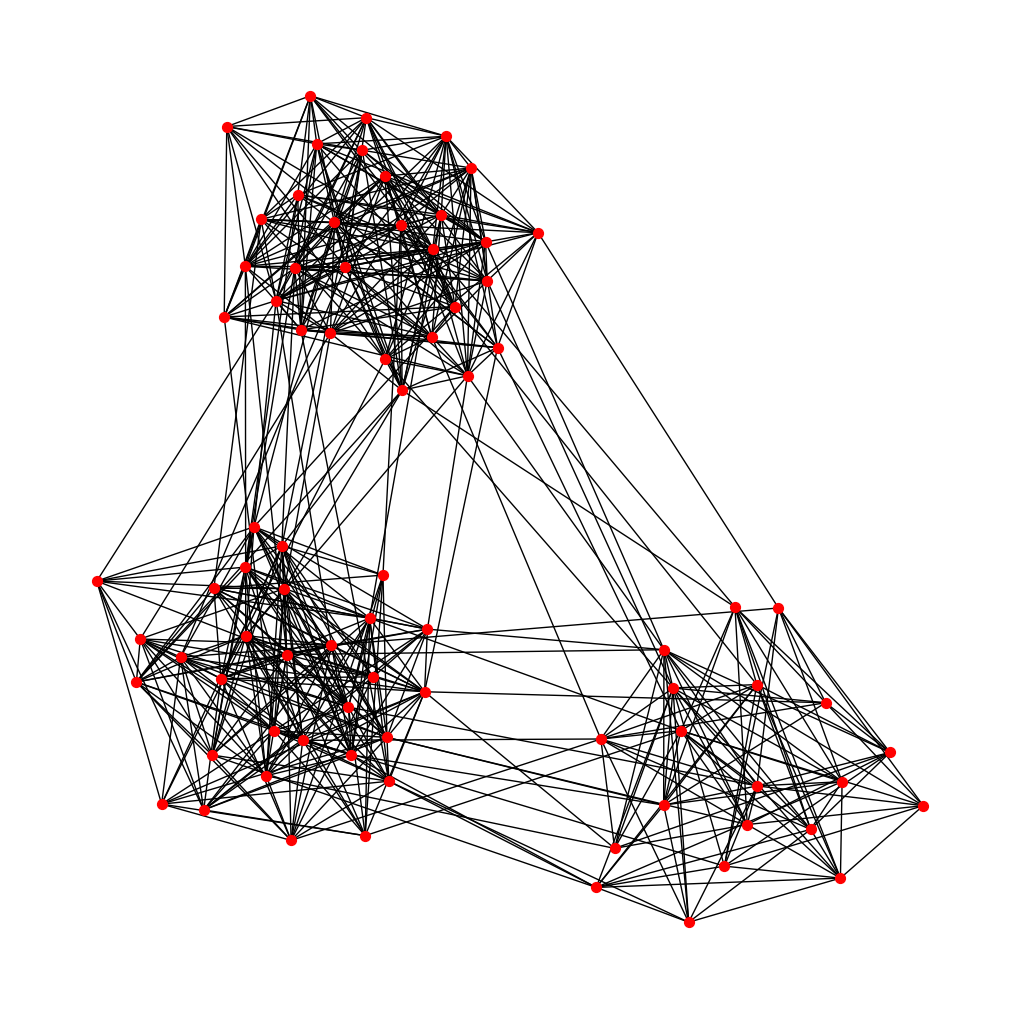

In [ ]:
# Probability of edge within the same community
p_in = 0.5

# Probability of edge between different communities
p_out = 0.02

# Define sizes of partitions (communities)
partition_sizes = [30, 30, 20]

# Define the probability matrix p
p = [
    [p_in, p_out, p_out],
    [p_out, p_in, p_out],
    [p_out, p_out, p_in]
]

# Generate stochastic block model graph
G = nx.stochastic_block_model(partition_sizes, p, seed=42)

# Desenhando o grafo
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, seed=42)  # Calculating the layout of the graph
nx.draw(G, pos, node_color="red", node_size=50, with_labels=False)
plt.show()


In [ ]:
--------------------

In [ ]:
# >>Network Parameters<< #

# Number of nodes
N = 150

# Average degree
av_degree = 6

# Connection probability for Erdős–Rényi models
p = float(av_degree)/float(N)

# Number of nodes added at each time step in the Barabasi-Albert and Waxman models
m = int(av_degree/2)

# Number of neighbors in the Small World model
kappa = av_degree

# >>Parameters for Networks with Communities<< #

# Define sizes of partitions (communities)
partition_sizes = [30, 30, 20]

# Probability of edge within the same community
p_in = 0.5

# Probability of edge between different communities
p_out = 0.02

seed = 42

# >>Parameters for LFV Networks with Communities<< #
tau1 = 2
tau2 = 2
mu = 0.1
minc = 20
maxc = 200

In [ ]:
def nonlinear_barabasi_albert_graph(n, m, alpha, seed=None):

    if seed is not None:
        np.random.seed(seed)
    G = nx.complete_graph(m)

    target_nodes = list(range(m))
    repeated_nodes = []

    for source in range(m, n):
        probs = np.array([G.degree(node)**alpha for node in target_nodes], dtype=np.float64)
        norm_probs = probs / probs.sum()
        new_edges = np.random.choice(target_nodes, size=m, replace=False, p=norm_probs)
        G.add_edges_from(zip([source] * m, new_edges))
        target_nodes.append(source)
        repeated_nodes.extend(new_edges)
        repeated_nodes.extend([source] * m)

    return G

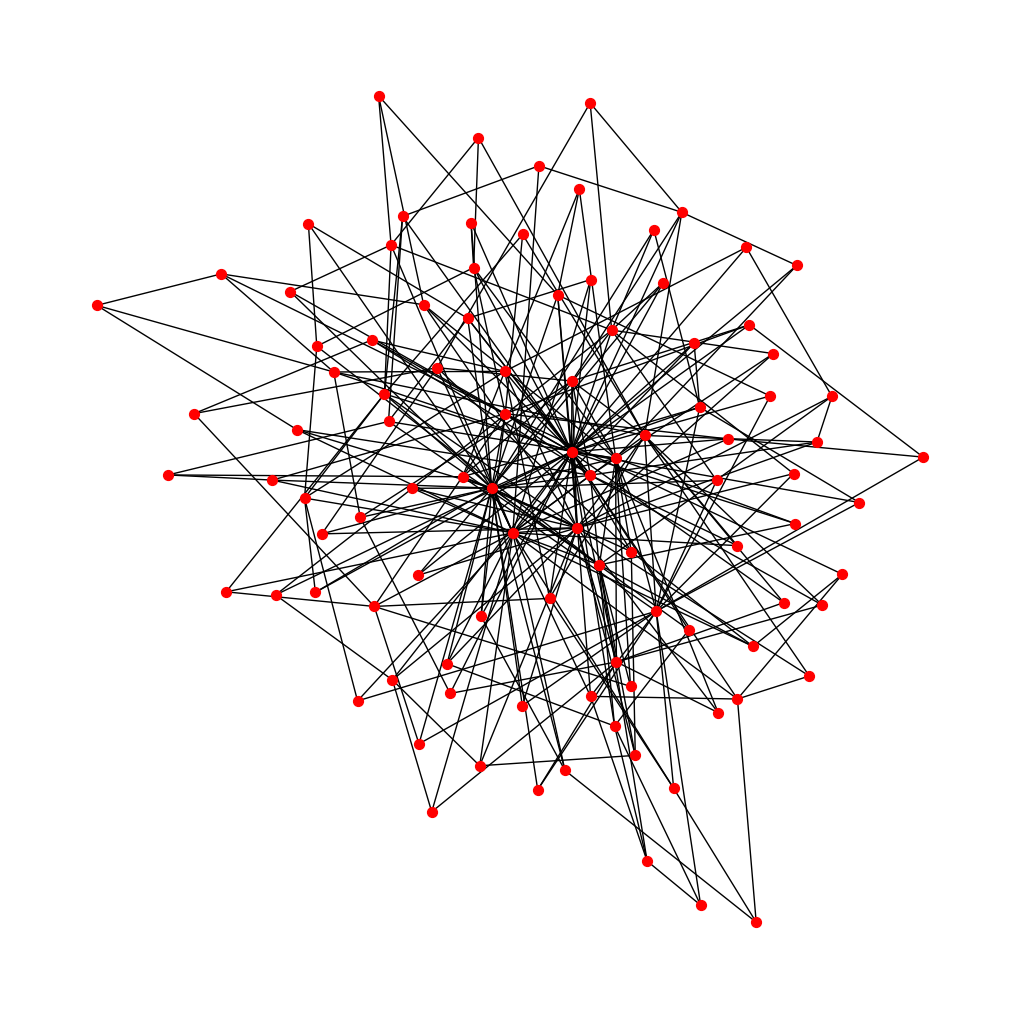

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Supondo que 'nonlinear_barabasi_albert_graph' é uma função definida em outro lugar
# from your_module import nonlinear_barabasi_albert_graph

# Geração do grafo
GB = nonlinear_barabasi_albert_graph(100, 3, 1.25, seed=42)

# Calculando as posições dos nós
pos = nx.spring_layout(GB, seed=42)

# Desenhando o grafo
plt.figure(figsize=(10, 10))
nx.draw(GB, pos, node_color="red", node_size=50, with_labels=False)
plt.show()


In [ ]:
def degree_distribution(G):
    vk = dict(G.degree())
    vk = list(vk.values())  # Pegamos apenas os valores dos graus
    vk = np.array(vk)
    maxk = np.max(vk)
    mink = np.min(vk)
    kvalues = np.arange(0, maxk + 1)  # Valores possíveis de k

    Pk = np.zeros(maxk + 1)  # P(k)
    for k in vk:
        Pk[k] += 1
    Pk = Pk / sum(Pk)  # A soma dos elementos de P(k) deve ser igual a um

    return kvalues, Pk

def measures(G):
    def momment_of_degree_distribution(G, m):
        M = 0
        N = len(G)
        for i in G.nodes:
            M += G.degree(i) ** m
        M /= N
        return M

    def shannon_entropy(G):
        k, Pk = degree_distribution(G)
        H = 0
        for p in Pk:
            if p > 0:
                H -= p * math.log(p, 2)
        return H

    knn = []
    for i in G.nodes():
        aux = nx.average_neighbor_degree(G, nodes=[i])
        knn.append(float(aux[i]))
    knn = np.array(knn)
    av_knn = np.mean(knn)

    N = len(G)
    M = G.number_of_edges()
    vk = dict(G.degree())
    vk = list(vk.values())
    vk = np.array(vk)
    k1 = momment_of_degree_distribution(G, 1)
    k2 = momment_of_degree_distribution(G, 2)
    variance = momment_of_degree_distribution(G, 2) - momment_of_degree_distribution(G, 1) ** 2
    av_cl = nx.average_clustering(G)
    l = nx.average_shortest_path_length(G)
    r = nx.degree_assortativity_coefficient(G)
    H = shannon_entropy(G)
    B = dict(nx.betweenness_centrality(G))
    B = list(B.values())
    av_B = np.mean(B)

    return k1, k2, variance, av_cl, l, r, H, av_B, av_knn

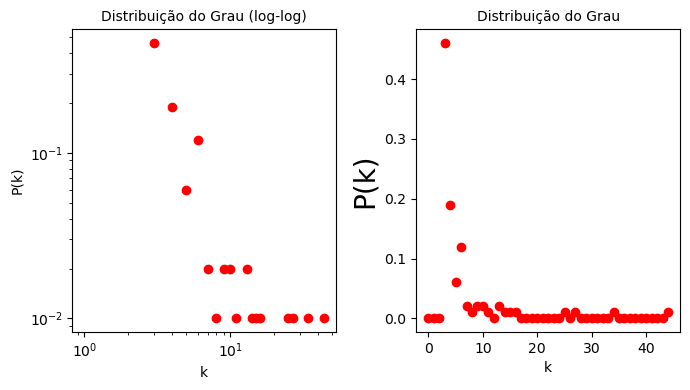

In [ ]:
ks, Pk = degree_distribution(GB)

plt.figure(figsize=(7, 4))

# Primeiro gráfico (log-log)
plt.subplot(1, 2, 1)
plt.xscale("log")
plt.yscale("log")
plt.plot(ks, Pk, "ro")
plt.xlabel("k", fontsize=10)
plt.ylabel("P(k)", fontsize=10)
plt.title("Distribuição do Grau (log-log)", fontsize=10)

# Segundo gráfico (linear)
plt.subplot(1, 2, 2)
plt.plot(ks, Pk, "ro")
plt.xlabel("k", fontsize=10)
plt.ylabel("P(k)", fontsize=20)
plt.title("Distribuição do Grau", fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
import math
import numpy as np
k1, k2, variance, av_cl, l, r, H, av_B, av_knn = measures(GB)
X_net = [k1, k2, variance, av_cl, l, r, H, av_B, av_knn]
print(X_net)

[5.88, 74.06, 39.485600000000005, 0.24443398407844363, 2.4454545454545453, -0.24109279423108015, 2.630618212304409, 0.014749536178107606, 14.837563543265015]


In [ ]:
vlbd_1, mvr_1, lambda_c1 = calculate_sync(GB)

C:\Users\victo\AppData\Local\Temp\ipykernel_14828\1785878281.py:63: ComplexWarning: Casting complex values to real discards the imaginary part
  vlbd = np.array(vlbd, dtype=float)


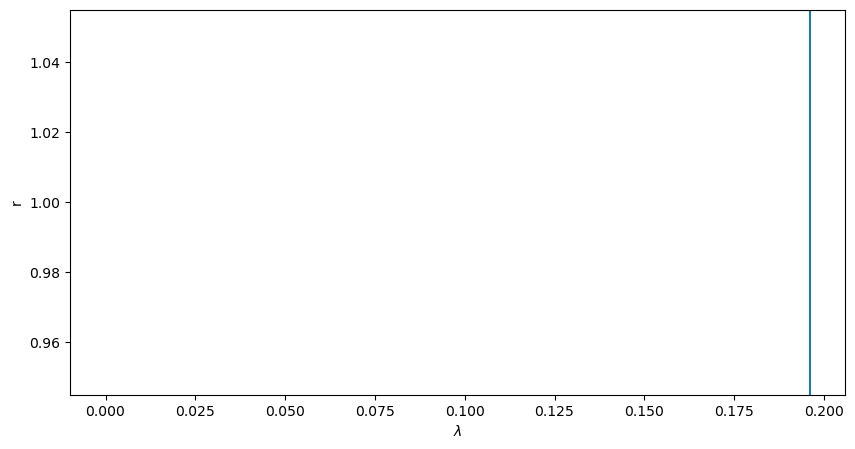

In [ ]:
# show the results
plt.figure(figsize=(10,5))
plt.plot(vlbd_1, mvr_1, '-o', color='red', linewidth=1)
plt.axvline(x =lambda_c1)
xlabel(r"$\lambda$")
ylabel("r")
plt.plot(True)

# Barabási-Classico

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Gerando o grafo utilizando o modelo de Barabási-Albert
G2 = nx.barabasi_albert_graph(150, 3, seed=42)

# Calculando as posições dos nós
pos = nx.spring_layout(G2, seed=42)

# Desenhando o grafo
plt.figure(figsize=(10, 10))
nx.draw(G2, pos, node_color="red", node_size=50, with_labels=False)
plt.show()


In [ ]:
ks, Pk = degree_distribution(G2)

plt.figure(figsize=(7, 4))

# Primeiro gráfico (log-log)
plt.subplot(1, 2, 1)
plt.xscale("log")
plt.yscale("log")
plt.plot(ks, Pk, "ro")
plt.xlabel("k", fontsize=10)
plt.ylabel("P(k)", fontsize=10)
plt.title("Distribuição do Grau (log-log)", fontsize=10)

# Segundo gráfico (linear)
plt.subplot(1, 2, 2)
plt.plot(ks, Pk, "ro")
plt.xlabel("k", fontsize=10)
plt.ylabel("P(k)", fontsize=20)
plt.title("Distribuição do Grau", fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
k1, k2, variance, av_cl, l, r, H, av_B, av_knn = measures(G2)
X_net = [k1, k2, variance, av_cl, l, r, H, av_B, av_knn]
print(X_net)

In [ ]:
vlbd_2, mvr_2, lambda_c2 = calculate_sync(G2)

In [ ]:
# show the results
plt.figure(figsize=(10,5))
plt.plot(vlbd_2, mvr_2, '-o', color='red', linewidth=1)
plt.axvline(x =lambda_c2)
xlabel(r"$\lambda$")
ylabel("r")
plt.plot(True)